In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from abc import abstractmethod
import torch
from torch import Tensor, nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np
from collections import OrderedDict

# Muons

## Muon generation

In [3]:
def generate_batch(n:int) -> Tensor:
    r'''
    Return tensor is (muons, coords),
    coords = (x~Uniform[0,1], y~Uniform[0,1], p=100GeV, theta~cos2(a) a~Uniform[0,0.5pi], phi~Uniform[0,2pi])
    '''
    
    batch = torch.stack([
        torch.rand(n),
        torch.rand(n),
        torch.zeros(n)+100,
        torch.clamp_max(torch.abs(torch.randn(n)/10),math.pi/2),  # Fix this
        torch.rand(n)*2*math.pi
    ], dim=1)
    return batch

In [4]:
x = generate_batch(10000)

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


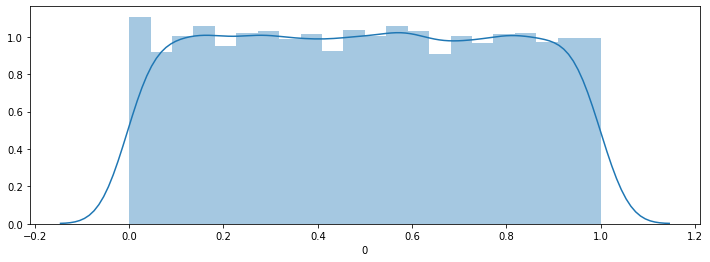

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


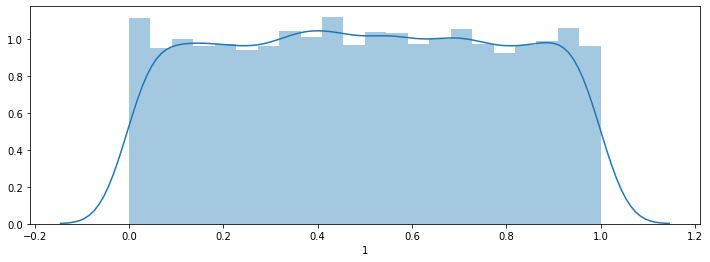

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/giles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


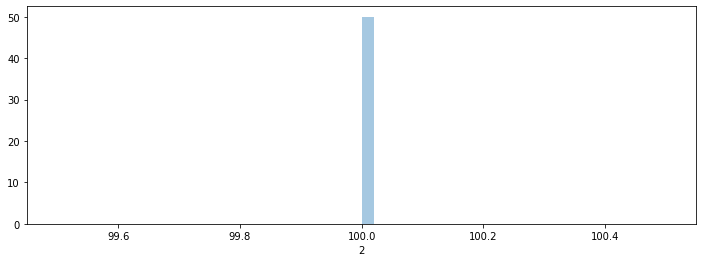

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


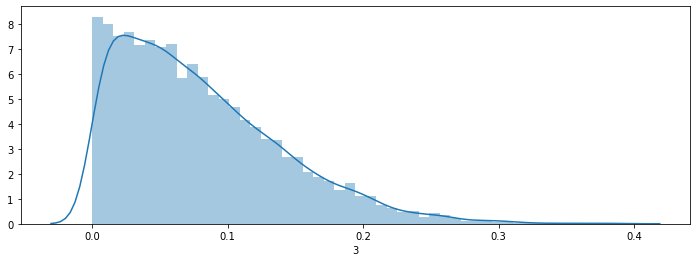

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


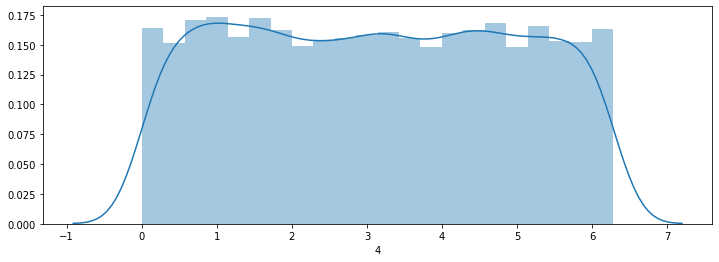

In [5]:
for i in range(x.shape[1]):
    plt.figure(figsize=(12,4))
    sns.distplot(x[:,i])
    plt.xlabel(i)
    plt.show()

## Muon Batch

In [6]:
class MuonBatch:
    def __init__(self, muons:Tensor, init_z:float, device:torch.device):
        r'''
        coords = (0:x~Uniform[0,1], 1:y~Uniform[0,1], 2:p=100GeV, 3:theta~cos2(a) a~Uniform[0,0.5pi], 4:phi~Uniform[0,2pi])
        '''
        
        self.muons = muons.to(device)
        self.z = init_z
        self.hits = []
        self.xy_hist = OrderedDict({})
        
    def __repr__(self) -> str:
        return f"Batch of {len(self)} muons"
        
    def __len__(self) -> int: return len(self.muons)
    
    @property
    def muons(self) -> Tensor: return self._muons
    
    @muons.setter
    def muons(self, muons:Tensor) -> None: self._muons = muons
        
    @property
    def x(self) -> Tensor: return self._muons[:,0]
    
    @x.setter
    def x(self, x:Tensor) -> None: self._muons[:,0] = x
        
    @property
    def y(self) -> Tensor: return self._muons[:,1]
    
    @y.setter
    def y(self, y:Tensor) -> None: self._muons[:,1] = y
        
    @property
    def xy(self) -> Tensor: return self._muons[:,:2]
    
    @xy.setter
    def xy(self, xy:Tensor) -> None: self._muons[:,:2] = xy
        
    @property
    def p(self) -> Tensor: return self._muons[:,2]
    
    @p.setter
    def p(self, p:Tensor) -> None: self._muons[:,2] = p
        
    @property
    def theta(self) -> Tensor: return self._muons[:,3]
    
    @theta.setter
    def theta(self, theta:Tensor) -> None: self._muons[:,3] = theta
        
    @property
    def phi(self) -> Tensor: return self._muons[:,4]
    
    @phi.setter
    def phi(self, phi:Tensor) -> None: self._muons[:,4] = phi
        
    def propagate(self, dz:float) -> None:
        self.x = self.x+(torch.sin(self.theta)*torch.cos(self.phi*dz))
        self.y = self.y+(torch.sin(self.theta)*torch.sin(self.phi*dz))
        self.z -= dz
        
    def get_xy_mask(self, lw:Tensor) -> Tensor:
        return (self.x >= 0)*(self.x < lw[0])*(self.y >= 0)*(self.y < lw[1])
    
    def snapshot_xyz(self) -> None:
        self.xy_hist[self.z] = self.xy.cpu().detach().clone().numpy()
        
    def append_hits(self, hits:Tensor) -> None:
        self.hits.append(hits)
        
    def get_hits(self) -> Tensor:
        return torch.stack(self.hits, dim=1)

In [7]:
batch = MuonBatch(generate_batch(1000), init_z=1, device=torch.device('cpu'))

In [8]:
batch.xy

tensor([[0.2089, 0.0245],
        [0.7606, 0.9852],
        [0.2211, 0.1879],
        ...,
        [0.4177, 0.7518],
        [0.0528, 0.1902],
        [0.5038, 0.3802]])

In [9]:
batch.snapshot_xyz()

In [10]:
batch.xy_hist

OrderedDict([(1, array([[0.20888472, 0.02446884],
                     [0.7606116 , 0.98519963],
                     [0.22107303, 0.18786424],
                     ...,
                     [0.417688  , 0.7518204 ],
                     [0.05278391, 0.19020557],
                     [0.50381833, 0.3801986 ]], dtype=float32))])

In [11]:
batch.propagate(0.1)

In [12]:
batch.xy

tensor([[0.2696, 0.0316],
        [0.8234, 1.0157],
        [0.2301, 0.1915],
        ...,
        [0.5729, 0.7750],
        [0.1079, 0.2248],
        [0.6244, 0.4536]])

In [13]:
batch.xy_hist

OrderedDict([(1, array([[0.20888472, 0.02446884],
                     [0.7606116 , 0.98519963],
                     [0.22107303, 0.18786424],
                     ...,
                     [0.417688  , 0.7518204 ],
                     [0.05278391, 0.19020557],
                     [0.50381833, 0.3801986 ]], dtype=float32))])

In [14]:
batch.snapshot_xyz()

In [15]:
batch.xy_hist

OrderedDict([(1, array([[0.20888472, 0.02446884],
                     [0.7606116 , 0.98519963],
                     [0.22107303, 0.18786424],
                     ...,
                     [0.417688  , 0.7518204 ],
                     [0.05278391, 0.19020557],
                     [0.50381833, 0.3801986 ]], dtype=float32)),
             (0.9, array([[0.26956767, 0.03158781],
                     [0.823375  , 1.0156515 ],
                     [0.23006989, 0.19153608],
                     ...,
                     [0.57287705, 0.7749757 ],
                     [0.10786794, 0.22480474],
                     [0.6244266 , 0.45359907]], dtype=float32))])

# Volume+Detector

In [16]:
class Layer(nn.Module):
    def __init__(self, lw:Tensor, z:float, size:float, device:torch.device):
        super().__init__()
        self.lw,self.z,self.size,self.device = lw,z,size,device
        
    def abs2idx(self, mu:MuonBatch, mask:Optional[Tensor]=None) -> Tensor:
        xy = mu.xy
        if mask is not None: xy = xy[mask]
        return torch.floor(xy/self.size).long()
                         
    @abstractmethod
    def forward(self, mu:MuonBatch) -> None: pass

## Volume

In [17]:
def arb_density(z:float, lw:Tensor, size:float) -> float:
    density = torch.ones(list((lw/size).long()))
    if z >= 0.3 and z <= 0.6: density[3:7,3:7] = 50
    return density

In [18]:
d = arb_density(0.3, lw=Tensor([1,1]), size=0.1);d

tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1., 50., 50., 50., 50.,  1.,  1.,  1.],
        [ 1.,  1.,  1., 50., 50., 50., 50.,  1.,  1.,  1.],
        [ 1.,  1.,  1., 50., 50., 50., 50.,  1.,  1.,  1.],
        [ 1.,  1.,  1., 50., 50., 50., 50.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [19]:
x = generate_batch(10)

In [20]:
idxs = torch.floor(x[:,:2]/0.1).long()

In [21]:
d[idxs[:,0],idxs[:,1]]

tensor([50.,  1., 50.,  1.,  1., 50., 50., 50.,  1.,  1.])

In [22]:
class VolumeLayer(Layer):
    def __init__(self, density_func:Callable[[float,Tensor,float],float],
                 lw:Tensor, z:float, size:float, device:torch.device):
        super().__init__(lw=lw, z=z, size=size, device=device)
        self.density = density_func(self.z, self.lw, size=self.size).to(self.device)
        
    def multi_scatter(self, mu:MuonBatch) -> None:
        r'''
        coords = (0:x~Uniform[0,1], 1:y~Uniform[0,1], 2:z=1, 3:p=100GeV, 4:theta~cos2(a) a~Uniform[0,0.5pi], 5:phi~Uniform[0,2pi])
        '''
        
        mask = mu.get_xy_mask(self.lw)  # Only scatter muons inside volume
        n = mask.sum()
        xy_idx = self.abs2idx(mu, mask)
        mu.phi[mask] = mu.phi[mask]+torch.randn(n)
        mu.theta[mask] = mu.theta[mask]+(torch.randn(n)*self.density[xy_idx[:,0],xy_idx[:,1]]/1000)  # Fix this
        return x
        
    def forward(self, mu:MuonBatch) -> None:
        mu.propagate(self.size/2)
        self.multi_scatter(mu)
        mu.propagate(self.size/2)

In [23]:
vl = VolumeLayer(arb_density, lw=Tensor([1,1]), z=0.5, size=0.1, device=torch.device('cpu'))

In [24]:
batch.phi

tensor([1.1678, 4.5173, 3.8749, 0.7263, 1.6986, 2.8888, 5.2398, 1.1211, 5.3137,
        5.4727, 2.3045, 6.2611, 1.2505, 3.0097, 1.4240, 5.8240, 5.4780, 1.0705,
        3.5006, 3.8061, 5.8924, 2.7803, 2.6781, 5.0724, 3.6163, 4.7150, 5.9334,
        0.2205, 1.3770, 0.0455, 3.4135, 1.2021, 3.5125, 2.6300, 3.1642, 5.7480,
        3.3395, 3.5359, 2.0816, 1.9611, 5.6564, 1.1843, 1.9167, 0.3949, 3.8798,
        2.3595, 0.5442, 3.8558, 3.4094, 1.7517, 2.9083, 1.4054, 0.1363, 2.7590,
        3.9760, 2.7082, 4.2785, 0.6579, 3.5782, 2.8251, 3.5306, 5.5289, 6.2101,
        0.1649, 3.7544, 1.5703, 5.0948, 2.2102, 2.0070, 4.7054, 1.8959, 0.2477,
        0.6862, 2.8945, 1.1416, 5.3145, 2.4865, 5.6293, 2.1133, 4.5488, 1.2599,
        1.2910, 2.1367, 4.4658, 4.3722, 1.2347, 1.8713, 1.7065, 3.7048, 1.3664,
        0.9044, 0.1864, 1.7300, 2.5735, 1.3586, 6.2603, 0.8097, 2.0783, 3.8048,
        5.9331, 0.0549, 1.0110, 2.1512, 4.6897, 0.5435, 3.8459, 1.9874, 3.0715,
        5.2311, 3.2040, 5.9945, 3.9656, 

In [25]:
vl(batch)

In [26]:
batch.phi

tensor([ 0.8979,  4.5173,  3.5489, -0.0575,  1.1593,  2.8888,  5.3367,  1.6633,
         7.7770,  6.0217,  2.3045,  6.3382,  1.2437,  3.0367,  1.5803,  6.0537,
         5.0598,  1.6246,  2.6962,  5.6665,  5.8924,  2.2879,  4.1369,  3.9451,
         2.4458,  3.5703,  6.1300, -1.7130,  0.8528,  0.0455,  3.4135,  1.4860,
         3.5125,  2.2914, -0.4070,  8.1457,  0.4944,  2.9787,  1.1734,  1.2879,
         4.9612,  1.3100,  2.5053, -0.4089,  4.7139,  1.3186,  1.1905,  4.2463,
         3.6701,  1.7517,  2.9261,  2.7877,  0.1001,  2.9560,  4.1849,  3.5616,
         3.9273, -0.2774,  4.0988,  3.5618,  3.5306,  6.1754,  5.6540, -0.7402,
         4.0149,  0.5641,  5.3337,  1.7064,  1.1920,  4.7054,  1.3851,  0.5261,
         0.1807,  2.2698,  1.9991,  3.9898,  0.4721,  5.1177,  2.1133,  4.0310,
         1.2599,  1.4754,  2.1367,  4.4658,  5.1559,  1.0128,  1.3055, -0.6928,
         2.7793,  1.4121,  1.7801,  1.1473,  2.1326,  2.7783,  1.2403,  3.3034,
         0.0431,  1.3750,  4.1346,  4.85

In [27]:
batch.xy

tensor([[0.3910, 0.0379],
        [0.9594, 1.0469],
        [0.2512, 0.1955],
        ...,
        [0.8856, 0.8075],
        [0.2345, 0.2581],
        [0.8935, 0.5376]])

In [28]:
batch.z

0.7999999999999999

## Detector

### Cost functions

In [29]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

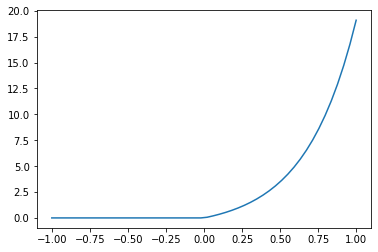

In [30]:
x = torch.linspace(-1,1,50)
plt.plot(x,eff_cost(x))

In [31]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x)**2

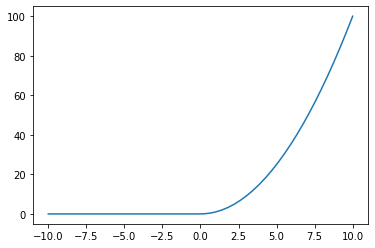

In [32]:
x = torch.linspace(-10,10,50)
plt.plot(x,res_cost(x))

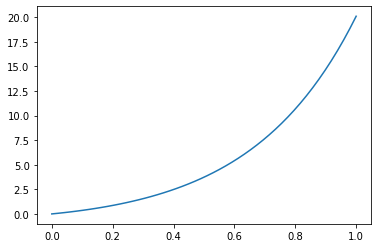

In [77]:
x = torch.linspace(0,1,50)
plt.plot(x,res_cost(x)+eff_cost(x))

### layer

In [34]:
class DetectorLayer(Layer):
    def __init__(self, init_res:float, init_eff:float, lw:Tensor, z:float, size:float,
                 eff_cost_func:Callable[[Tensor],Tensor], res_cost_func:Callable[[Tensor],Tensor], device:torch.device):
        super().__init__(lw=lw, z=z, size=size, device=device)
        self.resolution = nn.Parameter(torch.zeros(list((self.lw/size).long()), device=self.device)+init_res)
        self.efficiency = nn.Parameter(torch.zeros(list((self.lw/size).long()), device=self.device)+init_eff)
        self.eff_cost_func,self.res_cost_func = eff_cost_func,res_cost_func
        
    def get_hits(self, mu:MuonBatch) -> Tensor:  # to dense and add precision
        mask = mu.get_xy_mask(self.lw)
        res,eff = torch.zeros(len(mu)),torch.zeros(len(mu))  # Zero detection outside detector
        xy_idxs = self.abs2idx(mu, mask)
        res[mask] = self.resolution[xy_idxs[:,0],xy_idxs[:,1]]
        eff[mask] = self.efficiency[xy_idxs[:,0],xy_idxs[:,1]]
        
        hits = torch.stack([mu.x+(torch.randn(len(mu))/(res+1e-17)),
                            mu.y+(torch.randn(len(mu))/(res+1e-17)),
                            res,
                            eff], dim=1)
        return hits
        
    def forward(self, mu:MuonBatch) -> None:
        mu.propagate(self.size/2)
        mu.append_hits(self.get_hits(mu))
        mu.propagate(self.size/2)
        
    def get_cost(self) -> Tensor:
        return self.eff_cost_func(self.efficiency).sum()+self.res_cost_func(self.resolution).sum()

In [35]:
dl = DetectorLayer(1,1,Tensor([1,1]),1,0.1, eff_cost_func=eff_cost, res_cost_func=res_cost, device=torch.device('cpu'))

In [36]:
dl.resolution

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)

In [37]:
dl(batch)
dl(batch)
dl(batch)

In [38]:
hits = batch.get_hits()

In [39]:
hits.shape

torch.Size([1000, 3, 4])

# Propagator 

In [45]:
class Propagator(nn.Module):
    def __init__(self, layers:nn.ModuleList):
        super().__init__()
        self.layers = layers
        
    def forward(self, mu:MuonBatch) -> Tensor:
        cost = None
        for l in self.layers:
            l(mu)
            mu.snapshot_xyz()
            if hasattr(l, 'get_cost'):  # Get cost of detector layer
                if cost is None:
                    cost = l.get_cost()
                else:
                    cost = cost+l.get_cost()
        return cost

In [66]:
layers = []
lwh = Tensor([1,1,1])
size = 0.1
device = torch.device('cpu')
init_eff = 0.5
init_res = 0.5
for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
    if d:
        layers.append(DetectorLayer(init_eff=init_eff, init_res=init_eff, lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost, device=device))
    else:
        layers.append(VolumeLayer(density_func=arb_density, lw=lwh[:2], z=z, size=size, device=device))
layers = nn.ModuleList(layers) 

In [67]:
prop = Propagator(layers=layers); prop

Propagator(
  (layers): ModuleList(
    (0): DetectorLayer()
    (1): DetectorLayer()
    (2): VolumeLayer()
    (3): VolumeLayer()
    (4): VolumeLayer()
    (5): VolumeLayer()
    (6): VolumeLayer()
    (7): VolumeLayer()
    (8): DetectorLayer()
    (9): DetectorLayer()
  )
)

In [72]:
batch = MuonBatch(generate_batch(1000), init_z=1, device=torch.device('cpu'))

In [73]:
prop(batch)

tensor(1492.6757, grad_fn=<AddBackward0>)

In [63]:
hits = batch.get_hits()

In [64]:
hits.shape

torch.Size([1000, 4, 4])

In [65]:
hits

tensor([[[-5.3638e-01, -2.0056e+00,  5.0000e-01,  5.0000e-01],
         [-1.2812e+00, -7.6071e-03,  5.0000e-01,  5.0000e-01],
         [-1.7729e+00, -8.3224e-01,  5.0000e-01,  5.0000e-01],
         [ 3.4735e+00,  2.7839e+00,  5.0000e-01,  5.0000e-01]],

        [[ 5.2161e-01,  6.0431e+00,  5.0000e-01,  5.0000e-01],
         [ 2.9010e+00, -2.8314e+00,  5.0000e-01,  5.0000e-01],
         [-1.1647e+17,  7.0072e+16,  0.0000e+00,  0.0000e+00],
         [-4.3496e+16, -1.5255e+17,  0.0000e+00,  0.0000e+00]],

        [[ 4.4821e-01,  8.4655e-02,  5.0000e-01,  5.0000e-01],
         [ 3.0354e+00, -3.1751e-01,  5.0000e-01,  5.0000e-01],
         [ 1.6783e+17, -9.1497e+16,  0.0000e+00,  0.0000e+00],
         [-2.8836e+15,  9.3778e+15,  0.0000e+00,  0.0000e+00]],

        ...,

        [[ 1.4602e+00, -1.3110e+00,  5.0000e-01,  5.0000e-01],
         [-3.0084e+00,  5.0486e+00,  5.0000e-01,  5.0000e-01],
         [-1.7027e+00,  3.1479e+00,  5.0000e-01,  5.0000e-01],
         [ 3.0608e+00,  3.6619e+00,

# Loss

In [76]:
class DetectorLoss(nn.Module):
    def __init__(self, cost_coef:float):
        super().__init__()
        self.cost_coef = cost_coef
        
    def get_hit_loss(self, hits:Tensor) -> Tensor:
        # To write, assume muons already filtered, account for efficiency and resolution
        
    def forward(self, hits:Tensor, cost:Tensor) -> Tensor:
        loss = self.get_hit_loss(hits)
        loss = loss+(self.cost_coef*cost)
        return loss

IndentationError: expected an indented block (<ipython-input-76-8d26dce41046>, line 9)